In [ ]:
"""
Ejemplo: Riesgo de tasa de interés en el modelo de Merton
---------------------------------------------------------
Objetivo general:
- Usar datos reales (AAPL, MSFT, GOOGL y ^IRX) para:
  1) Estimar parámetros (retornos y riesgos) de las acciones.
  2) Construir el portafolio óptimo de Merton.
  3) Medir la sensibilidad de ese portafolio a cambios en la tasa libre de riesgo.
"""

import numpy as np              # Operaciones numéricas (arrays, álgebra lineal)
import pandas as pd             # Manejo de series y tablas de datos

from Do_portfolio import Do_portfolio  # Clase con métodos de portafolios y Merton
from yahoo_data import yahoo_data            # Clase para descargar y procesar datos de Yahoo Finance

# Para graficar al final
import matplotlib.pyplot as plt  # Librería de gráficos básicos

# %%
# ----------------------------
# 1. Definir universo y fechas
# ----------------------------

tickers = ["AAPL", "MSFT", "GOOGL"]   # Lista de símbolos de las 3 acciones riesgosas
rf_ticker = "^IRX"                    # Símbolo de la tasa libre de riesgo (T-Bill 13 semanas)

start = "2020-01-01"                  # Fecha de inicio del periodo de estudio
end   = "2024-12-31"                  # Fecha de fin del periodo de estudio

In [3]:
# %%
# ------------------------------------------
# 2. Descargar y alinear datos (acciones + rf)
# ------------------------------------------

# Llamamos a un método de clase que:
# - Descarga precios ajustados de las acciones y de ^IRX.
# - Alinea calendarios (mismas fechas para todos).
# - Elimina filas con valores faltantes.
data_all = yahoo_data.preprocess_data(
    tickers=tickers,          # Lista de acciones riesgosas
    rf_ticker=rf_ticker,      # Ticker de la tasa libre de riesgo
    start=start,              # Fecha inicial
    end=end,                  # Fecha final
    price_col="Adj Close",    # Usar columna de precios ajustados
    auto_adjust=False         # No ajustar automáticamente (ya usamos Adj Close)
)

# Mostrar las columnas descargadas (acciones + ^IRX)
print("Columnas en data_all:", data_all.columns)
# Vista rápida de las primeras filas para verificar que los datos se ven razonables
data_all.head()

Columnas en data_all: Index(['AAPL', 'GOOGL', 'MSFT', '^IRX'], dtype='object', name='Ticker')


Ticker,AAPL,GOOGL,MSFT,^IRX
Date,,,,
2020-01-02,72.468285,67.965233,152.791153,1.495
2020-01-03,71.763718,67.609680,150.888565,1.473
2020-01-06,72.335564,69.411758,151.278656,1.488
2020-01-07,71.995369,69.277687,149.899277,1.500
2020-01-08,73.153488,69.770782,152.286957,1.493


In [4]:
# %%
# -------------------------------------
# 3. Separar activos y tasa libre de rf
#    y convertir la tasa a unidades útiles
# -------------------------------------

# Extraemos solo las columnas de las acciones (precios de AAPL, MSFT, GOOGL)
prices_assets = data_all[tickers]

# Extraemos la columna de la tasa libre de riesgo como DataFrame de 1 columna
rf_raw = data_all[[rf_ticker]]   # Sigue en % anual (como se reporta en Yahoo)

# Convertir tasa: de "% anual" a:
# - rf_ann: tasa anual en proporción (ej: 5% -> 0.05)
# - rf_daily_log: tasa diaria equivalente en log-retornos
rf_ann, rf_daily_log = yahoo_data.convert_rf(
    data_rf=rf_raw,       # DataFrame con la serie de ^IRX
    days_per_year=252,    # Número de días hábiles que usamos para anualizar
    kind="log"            # Pedimos tasa diaria en formato log (para futuros usos)
)

# Imprimir las primeras filas de la tasa anual en proporción
print("rf_ann (primeros días):")
print(rf_ann.head())

# Imprimir las primeras filas de la tasa diaria en log-retornos
print("\nrf_daily_log (primeros días):")
print(rf_daily_log.head())


rf_ann (primeros días):
            ^IRX_ann
Date                
2020-01-02   0.01495
2020-01-03   0.01473
2020-01-06   0.01488
2020-01-07   0.01500
2020-01-08   0.01493

rf_daily_log (primeros días):
            ^IRX_daily_log
Date                      
2020-01-02        0.000059
2020-01-03        0.000058
2020-01-06        0.000059
2020-01-07        0.000059
2020-01-08        0.000059


In [5]:
# %%
# ---------------------------------------------------
# 4. Estimar μ (retorno esperado) y Σ (covarianza) anuales
#    con la clase Do_portfolio
# ---------------------------------------------------

# Creamos una instancia de Do_portfolio con los mismos tickers y periodo
dp = Do_portfolio(
    tickers=tickers,  # Lista de acciones
    start=start,      # Fecha inicial
    end=end           # Fecha final
)

# Calcula retornos diarios, estima la media histórica y la anualiza
dp.mean_estimation(tipo="hist", periods_per_year=252)  # Guarda resultado en dp.bar_mu

# Calcula la matriz de covarianza diaria y la anualiza
dp.var_estimation(tipo="hist", periods_per_year=252)   # Guarda resultado en dp.bar_var

# Guardamos μ anual y Σ anual en variables auxiliares
mu_ann = dp.bar_mu       # Serie: retorno esperado anual por acción
Sigma_ann = dp.bar_var   # DataFrame: matriz de covarianza anual

# Mostramos los retornos esperados anuales
print("μ_ann (retornos esperados anuales):")
print(mu_ann)

# Mostramos la matriz de covarianza anual
print("\nΣ_ann (covarianza anual):")
print(Sigma_ann)


μ_ann (retornos esperados anuales):
Ticker
AAPL     0.299545
GOOGL    0.259848
MSFT     0.250702
dtype: float64

Σ_ann (covarianza anual):
Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    0.100420  0.066844  0.072340
GOOGL   0.066844  0.105677  0.073995
MSFT    0.072340  0.073995  0.093067


In [6]:
# %%
# --------------------------------------------
# 5. Fijar preferencias del inversor y tasa base
# --------------------------------------------

gamma = 3.0  # Aversión al riesgo (CRRA) del inversor; 3 ~ nivel intermedio

# Tomamos el último valor disponible de la tasa anual rf_ann como tasa base r0
# - rf_ann es un DataFrame de 1 columna, por eso usamos iloc[-1, 0]
r0 = float(rf_ann.iloc[-1, 0])

# Mostramos parámetros clave
print(f"gamma = {gamma}")
print(f"r0 (tasa libre anual usada en Merton) = {r0:.4f}")


gamma = 3.0
r0 (tasa libre anual usada en Merton) = 0.0418


In [7]:
# %%
# ------------------------------------------------------
# 6. Calcular portafolio de Merton y sensibilidad a la tasa
# ------------------------------------------------------

# Llamamos al método que:
# - Usa μ_ann y Σ_ann (cuando use_bar=True).
# - Aplica la regla de Merton.
# - Devuelve portafolio óptimo y sensibilidad dπ/dr.
res_merton_ir = dp.interest_rate_risk_merton(
    gamma=gamma,        # Aversión al riesgo
    r0=r0,              # Tasa libre de riesgo anual base
    dr=1e-4,            # Paso pequeño para derivada numérica de verificación
    use_bar=True,       # Indica que use dp.bar_mu y dp.bar_var ya estimados
    kind="simple",      # (si use_bar=False, controlaría el tipo de retorno diario)
    periods_per_year=252
)

# Extraemos el portafolio óptimo de Merton a la tasa r0
pi_merton = res_merton_ir["pi"]

# Extraemos la derivada analítica de los pesos con respecto a la tasa
dpi_dr_analytic = res_merton_ir["dpi_dr_analytic"]

# Extraemos la derivada numérica (cociente incremental) para chequeo
dpi_dr_numeric = res_merton_ir["dpi_dr_numeric"]

# Imprimimos el portafolio óptimo
print("Pesos Merton π(r0):")
print(pi_merton)

# Imprimimos la sensibilidad analítica
print("\nDerivada analítica dπ/dr:")
print(dpi_dr_analytic)

# Imprimimos la sensibilidad numérica de chequeo
print("\nDerivada numérica dπ/dr (chequeo):")
print(dpi_dr_numeric)


Pesos Merton π(r0):
AAPL     0.669435
GOOGL    0.236365
MSFT     0.039871
Name: pi_Merton, dtype: float64

Derivada analítica dπ/dr:
AAPL    -1.432313
GOOGL   -1.172956
MSFT    -1.535753
Name: dpi_dr_analytic, dtype: float64

Derivada numérica dπ/dr (chequeo):
AAPL    -1.432313
GOOGL   -1.172956
MSFT    -1.535753
Name: dpi_dr_numeric, dtype: float64


In [8]:
# %%
# -------------------------------------------------
# 7. Aplicar un shock de tasa y aproximar nuevos pesos
# -------------------------------------------------

delta_r = 0.01   # Shock de tasa: +100 puntos básicos (1% en términos absolutos)

# Cambio aproximado en los pesos de Merton ante el shock:
# Δπ ≈ (dπ/dr) * Δr   (cálculo componente a componente)
delta_pi = dpi_dr_analytic * delta_r

# Nuevos pesos aproximados del portafolio a la tasa r0 + 1%
pi_new = pi_merton + delta_pi

# Mostrar el cambio en los pesos ante el shock
print("Cambio en pesos ante +100 bps (Δπ):")
print(delta_pi)

# Mostrar los nuevos pesos aproximados luego del shock de tasa
print("\nNuevos pesos aproximados π(r0 + 1%):")
print(pi_new)


Cambio en pesos ante +100 bps (Δπ):
AAPL    -0.014323
GOOGL   -0.011730
MSFT    -0.015358
Name: dpi_dr_analytic, dtype: float64

Nuevos pesos aproximados π(r0 + 1%):
AAPL     0.655112
GOOGL    0.224635
MSFT     0.024513
dtype: float64


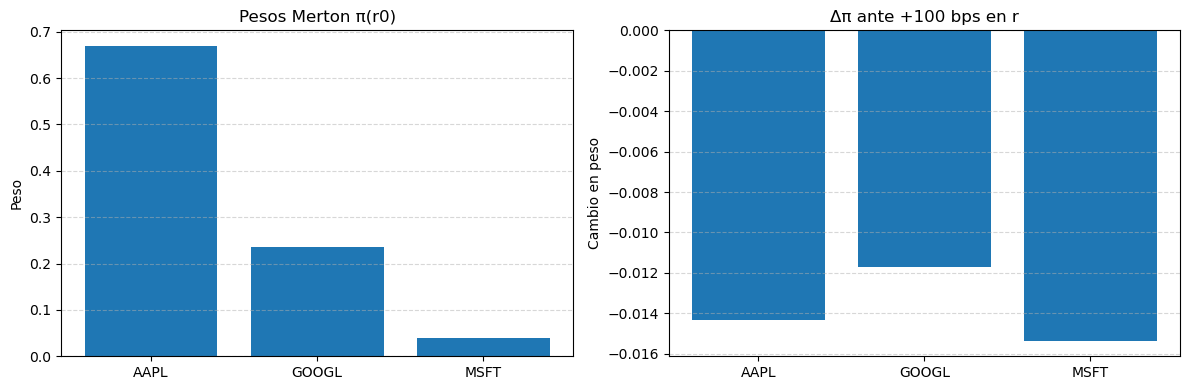

In [9]:
# %%
# -----------------------------
# 8. Visualizar resultados (plots)
# -----------------------------

# Creamos una figura con 2 subgráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Panel izquierdo: pesos Merton base ---
axes[0].bar(pi_merton.index, pi_merton.values)     # Barras con los pesos iniciales
axes[0].set_title("Pesos Merton π(r0)")            # Título del gráfico
axes[0].set_ylabel("Peso")                         # Etiqueta del eje Y
axes[0].grid(axis="y", ls="--", alpha=0.5)         # Líneas guía horizontales

# --- Panel derecho: cambio en pesos ante +100 bps ---
axes[1].bar(delta_pi.index, delta_pi.values)       # Barras con el cambio Δπ
axes[1].set_title("Δπ ante +100 bps en r")         # Título del gráfico
axes[1].set_ylabel("Cambio en peso")               # Etiqueta del eje Y
axes[1].grid(axis="y", ls="--", alpha=0.5)         # Líneas guía horizontales

# Ajustar espaciado para que los gráficos no se encimen
plt.tight_layout()

# Mostrar la figura en pantalla
plt.show()


In [10]:
# %%
# 9. Calibrar un modelo de Vasicek sobre la tasa libre de riesgo (^IRX)

# Usamos la serie anual en proporción (rf_ann) que ya calculamos antes.
# rf_ann tiene una sola columna, tomamos esa serie:
rf_series = rf_ann.iloc[:, 0]   # equivalente a rf_ann["^IRX_ann"] si ese es el nombre

# Llamamos al método de la clase Do_portfolio que combina todo:
# - calibra un Vasicek sobre rf_series,
# - simula trayectorias futuras de la tasa,
# - aplica la regla de Merton en el último punto de cada trayectoria.
res_vas_merton = dp.merton_vasicek_scenarios(
    rf_series=rf_series,
    gamma=gamma,          # misma aversión al riesgo que usamos antes (γ = 3)
    horizonte_anios=1.0,  # horizonte de 1 año hacia adelante
    n_paths=1000,         # número de trayectorias de tasa a simular
    pasos_por_anio=252,   # pasos por año (diarios)
    use_bar=True,         # usa μ y Σ ya estimados en dp.bar_mu y dp.bar_var
    kind="simple",
    periods_per_year=252,
    seed=42               # semilla para reproducibilidad
)

print("Parámetros calibrados del modelo de Vasicek:\n")
print(res_vas_merton["params_vasicek"])


Advertencia: b_hat fuera de (0,1); revisar la estabilidad de la calibración.
Parámetros calibrados del modelo de Vasicek:

{'kappa': -0.005489647788953996, 'theta': -0.9573921958716067, 'sigma': 0.0058700306720484, 'a': 2.085636189706752e-05, 'b': 1.0000217845539028}


In [11]:
# %%
# 10. Resumen de los pesos de Merton bajo escenarios de tasa Vasicek

# DataFrame con los pesos de Merton al final del horizonte,
# para cada trayectoria de tasa simulada (filas = paths, columnas = activos).
weights_paths = res_vas_merton["weights_paths"]

print("Dimensión de weights_paths (paths x activos):", weights_paths.shape)
print("\nEjemplo de las primeras filas de pesos simulados:")
print(weights_paths.head())

# Resumen estadístico por activo: media, desvío, percentiles, etc.
summary_weights = res_vas_merton["summary_weights"]

print("\nResumen estadístico de los pesos de Merton por activo (escenarios Vasicek):")
print(summary_weights)

# Suma de pesos en activos riesgosos en cada trayectoria (exposición total a riesgo)
total_risky = weights_paths.sum(axis=1)

print("\nResumen de la exposición total a activos riesgosos:")
print(total_risky.describe(percentiles=[0.05, 0.5, 0.95]))


Dimensión de weights_paths (paths x activos): (1000, 3)

Ejemplo de las primeras filas de pesos simulados:
            AAPL     GOOGL      MSFT
path_0  0.679143  0.244315  0.050280
path_1  0.660789  0.229285  0.030600
path_2  0.653356  0.223197  0.022630
path_3  0.669841  0.236698  0.040306
path_4  0.664943  0.232686  0.035054

Resumen estadístico de los pesos de Merton por activo (escenarios Vasicek):
        count      mean       std       min        5%       50%       95%  \
AAPL   1000.0  0.661555  0.008606  0.632742  0.647990  0.661747  0.675194   
GOOGL  1000.0  0.229912  0.007048  0.206316  0.218803  0.230069  0.241081   
MSFT   1000.0  0.031422  0.009228  0.000528  0.016876  0.031627  0.046045   

            max  
AAPL   0.693364  
GOOGL  0.255961  
MSFT   0.065528  

Resumen de la exposición total a activos riesgosos:
count    1000.000000
mean        0.922888
std         0.024882
min         0.839586
5%          0.883669
50%         0.923443
95%         0.962320
max         1

<Figure size 1000x400 with 0 Axes>

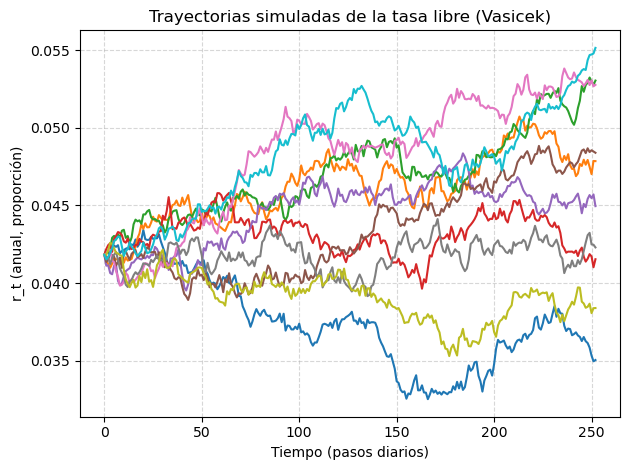

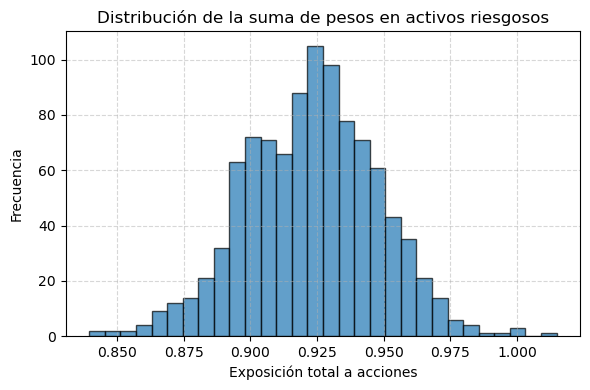

In [12]:
# %%
# 11. Gráficos: tasa Vasicek simulada y exposición total a riesgo

# --- 11.1 Trayectorias simuladas de la tasa corta ---
plt.figure(figsize=(10, 4))
# Graficamos solo las primeras 10 trayectorias para no saturar el gráfico
res_vas_merton["r_paths"].iloc[:, :10].plot(legend=False)
plt.title("Trayectorias simuladas de la tasa libre (Vasicek)")
plt.ylabel("r_t (anual, proporción)")
plt.xlabel("Tiempo (pasos diarios)")
plt.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 11.2 Histograma de la exposición total a activos riesgosos ---
total_risky = weights_paths.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(total_risky, bins=30, edgecolor="black", alpha=0.7)
plt.title("Distribución de la suma de pesos en activos riesgosos")
plt.xlabel("Exposición total a acciones")
plt.ylabel("Frecuencia")
plt.grid(ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Resumen del experimento

**Pasos principales**

1. **Datos de mercado (2020–2024)**  
   - Acciones riesgosas: AAPL, GOOGL, MSFT.  
   - Tasa libre de riesgo: T-Bill a 13 semanas (^IRX).  

2. **Tratamiento de datos**  
   - Descarga y alineación de precios diarios con `yahoo_data.preprocess_data`.  
   - Conversión de ^IRX de “% anual” a tasa anual en proporción y tasa diaria con `convert_rf`.  
   - Se toma el último valor de la serie anual como tasa base \(r_0\).

3. **Estimación de parámetros de las acciones**  
   - Con `Do_portfolio` se calculan retornos simples diarios.  
   - Se obtiene el retorno esperado anual (μ) y la matriz de covarianza anual (Σ) para las tres acciones.

4. **Merton e interest rate risk (análisis estático)**  
   - Con μ, Σ, \(r_0\) y una aversión al riesgo \(\gamma = 3\) se aplica `interest_rate_risk_merton`.  
   - El método entrega el **portafolio óptimo de Merton** \(\pi(r_0)\) y la **sensibilidad dπ/dr** de cada peso frente a la tasa.  
   - Se simula un **shock de +1% en la tasa libre** y se aproximan los nuevos pesos óptimos.

5. **Modelo de Vasicek + Merton (escenarios estocásticos de tasa)**  
   - Se calibra un modelo de **Vasicek** sobre la serie histórica de tasas (rf_ann) dentro de `merton_vasicek_scenarios`.  
   - Con los parámetros calibrados se simulan **1000 trayectorias de la tasa** a 1 año.  
   - Para la tasa final de cada trayectoria se vuelve a aplicar la regla de Merton, obteniendo una **distribución de portafolios óptimos** y de la **exposición total a renta variable**.

---

### Conclusiones del ejercicio

- El portafolio óptimo de Merton con los datos históricos queda **fuertemente concentrado en AAPL**, con un peso importante en GOOGL y una posición pequeña en MSFT; el resto se mantiene en el activo libre de riesgo.  
- Todas las sensibilidades dπ/dr son **negativas**: al simular un aumento de la tasa libre de **1 punto porcentual**, los pesos en AAPL, GOOGL y MSFT caen ligeramente y la **suma de pesos en acciones baja aproximadamente de ~95% a ~90%**. El modelo se vuelve más conservador y traslada parte de la riqueza al activo seguro: eso es el **interest rate risk** en este caso.  
- Con el modelo de Vasicek, las tasas simuladas a un año generan una **distribución de portafolios de Merton** donde:  
  - La estructura relativa se mantiene (AAPL domina, GOOGL complementa, MSFT es marginal).  
  - La **exposición total a renta variable** se concentra alrededor de **0.92**, con un rango típico aproximadamente entre **0.88 y 0.96**.  
- En conjunto, el ejercicio muestra que la incertidumbre en las tasas no cambia la dirección de la política óptima (el agente sigue prefiriendo un portafolio cargado a acciones), pero sí ajusta el **nivel de riesgo**: ante tasas más altas, el inversionista reduce su posición en renta variable y aumenta su posición en el activo libre de riesgo.

